## Tree and Random Forest

In [2]:
library(ggplot2)
library(readr)
library(tidyverse)
library(mvtnorm)
library(rpart)
library(rpart.plot)
library(randomForest)
library(gbm)
library(tree)

### 1. Exploratory Data Analysis

In [3]:
train.data = read_csv("bank_marketing_train.csv", show_col_types = FALSE)
test.data = read_csv("bank_marketing_test.csv", show_col_types = FALSE)
str(train.data)

spec_tbl_df [7,813 × 17] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ age      : num [1:7813] 27 50 34 27 36 38 34 30 33 33 ...
 $ job      : chr [1:7813] "blue-collar" "blue-collar" "management" "student" ...
 $ marital  : chr [1:7813] "married" "divorced" "single" "single" ...
 $ education: chr [1:7813] "secondary" "secondary" "tertiary" "tertiary" ...
 $ default  : chr [1:7813] "no" "no" "no" "no" ...
 $ balance  : num [1:7813] 61 204 171 118 62 ...
 $ housing  : chr [1:7813] "yes" "yes" "yes" "no" ...
 $ loan     : chr [1:7813] "no" "yes" "no" "no" ...
 $ contact  : chr [1:7813] "unknown" "unknown" "cellular" "cellular" ...
 $ day      : num [1:7813] 19 14 7 31 13 7 20 21 16 28 ...
 $ month    : chr [1:7813] "jun" "may" "may" "aug" ...
 $ duration : num [1:7813] 1012 421 191 160 311 ...
 $ campaign : num [1:7813] 1 1 1 3 1 2 1 1 5 1 ...
 $ pdays    : num [1:7813] -1 -1 294 98 91 -1 -1 -1 -1 -1 ...
 $ previous : num [1:7813] 0 0 1 1 2 0 0 0 0 0 ...
 $ poutcome : chr [1:7813] "unknown"

#### Boxplots

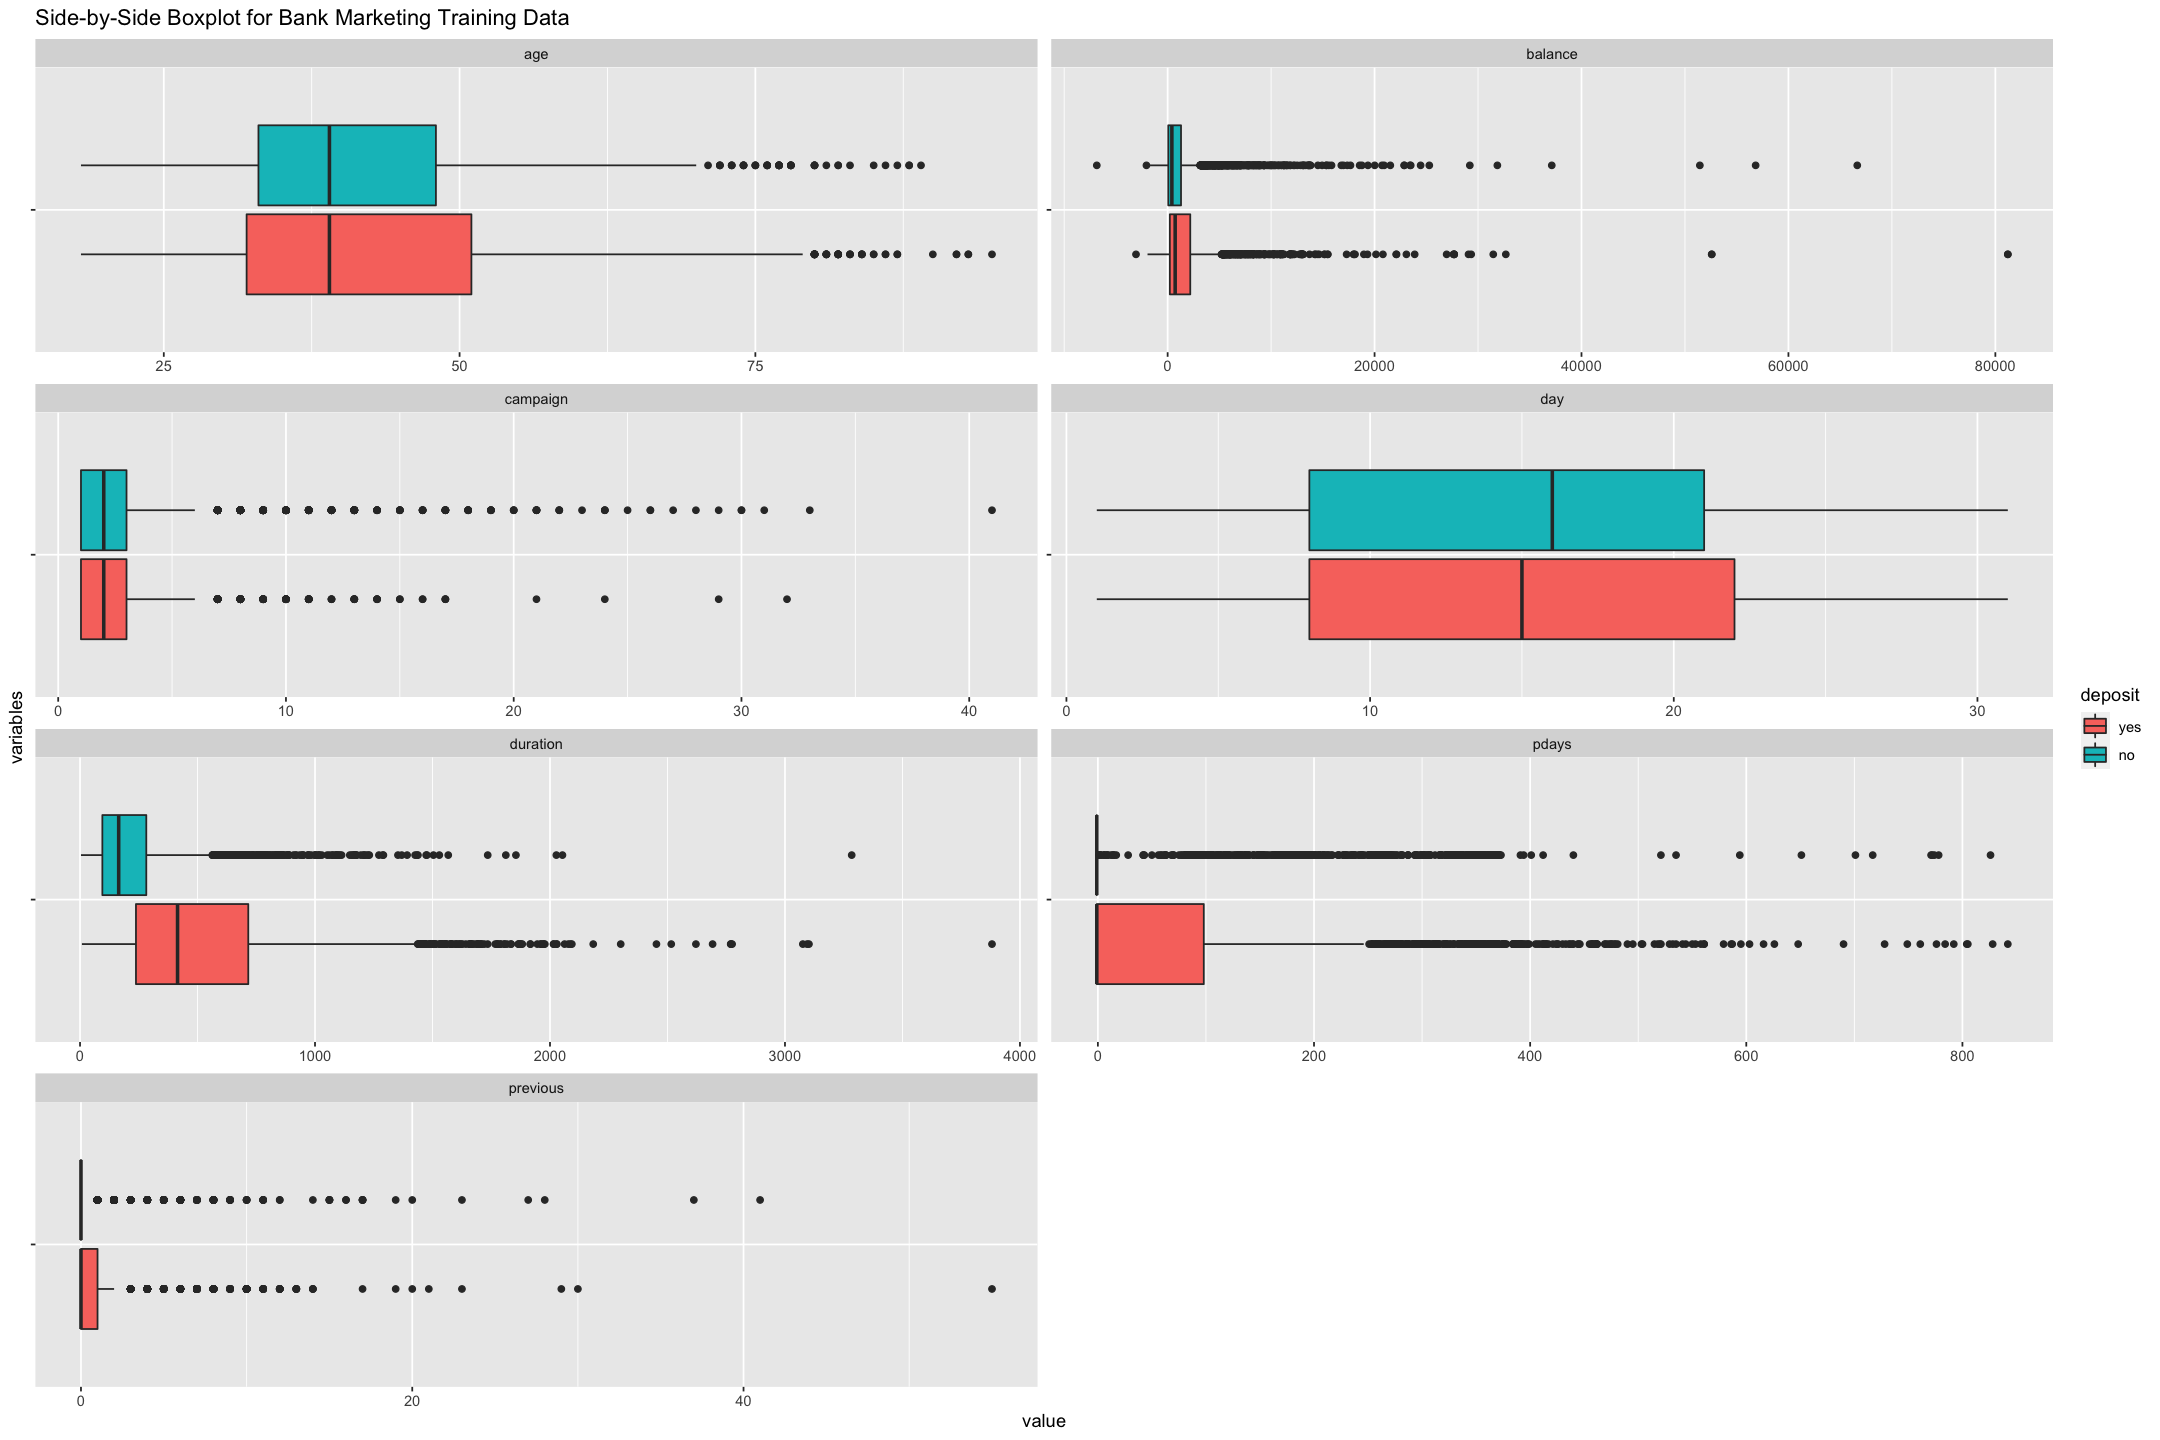

In [4]:
train.boxplot = train.data %>% select(age, balance, day, duration, campaign, pdays, previous, deposit) %>%
    gather(key = "variables", value = "value", -deposit) %>%
    mutate(deposit = factor(deposit, levels = c("yes", "no")))
options(repr.plot.width=18, repr.plot.height=12)
train.boxplot %>% ggplot(mapping = aes(x = variables, y = value, fill = deposit)) + 
    facet_wrap(~variables, ncol = 2, scales = "free") + 
    geom_boxplot() + coord_flip() + theme(axis.text.y = element_blank()) + 
    ggtitle("Side-by-Side Boxplot for Bank Marketing Training Data")

Based on the side-by-size boxplots above, `duration` is obviously different for deposit "yes" class (subscribing deposit) and "no" class (not subscribing deposit). And for other variables, there is no significant difference for these two classes.

#### Mosaic Plots

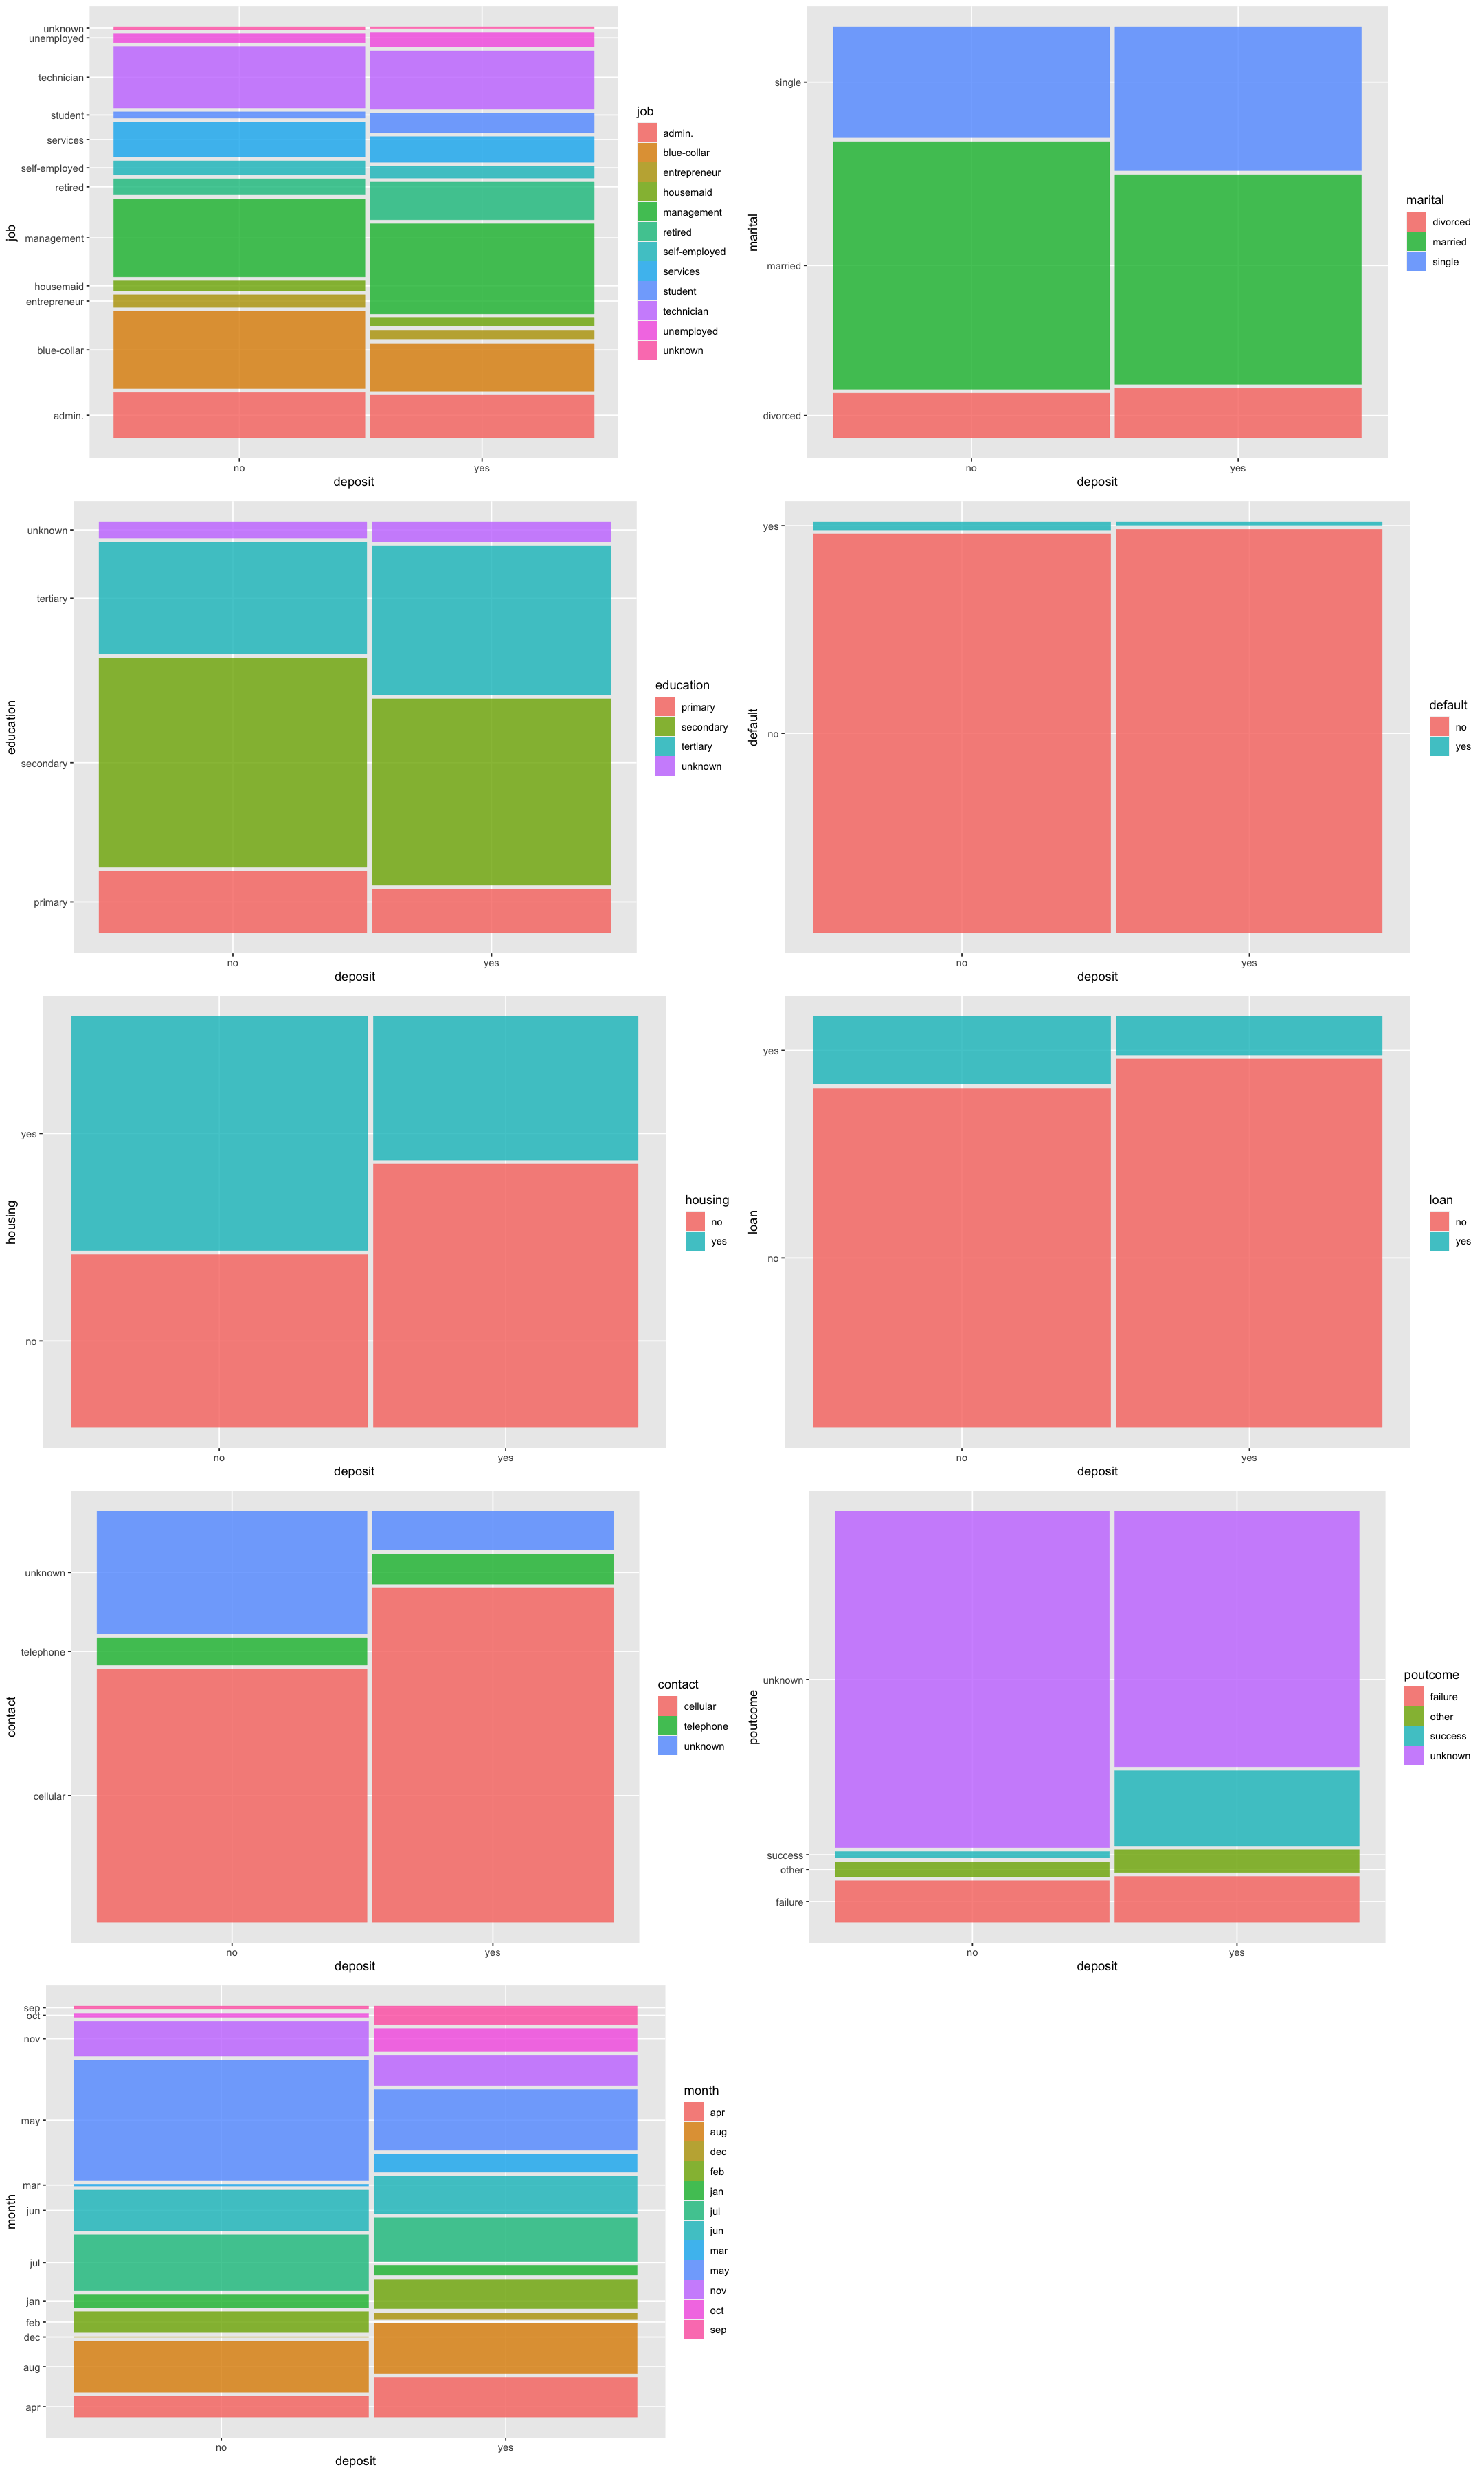

In [5]:
library(ggmosaic)
library(ggpubr)
options(repr.plot.width=18, repr.plot.height=30)
job.mos = ggplot(data = train.data) + geom_mosaic(mapping = aes(x = product(deposit), fill = job))
marital.mos = ggplot(data = train.data) + geom_mosaic(mapping = aes(x = product(deposit), fill = marital))
education.mos = ggplot(data = train.data) + geom_mosaic(mapping = aes(x = product(deposit), fill = education))
default.mos = ggplot(data = train.data) + geom_mosaic(mapping = aes(x = product(deposit), fill = default))
housing.mos = ggplot(data = train.data) + geom_mosaic(mapping = aes(x = product(deposit), fill = housing))
loan.mos = ggplot(data = train.data) + geom_mosaic(mapping = aes(x = product(deposit), fill = loan))
contact.mos = ggplot(data = train.data) + geom_mosaic(mapping = aes(x = product(deposit), fill = contact))
poutcome.mos = ggplot(data = train.data) + geom_mosaic(mapping = aes(x = product(deposit), fill = poutcome))
month.mos = ggplot(data = train.data) + geom_mosaic(mapping = aes(x = product(deposit), fill = month))
ggarrange(job.mos, marital.mos, education.mos, default.mos, housing.mos, loan.mos, 
          contact.mos, poutcome.mos, month.mos, ncol = 2, nrow = 5)

Based on the mosiac plots above, 

+ `job`: blue collar accounts for a higher proportion for not subscribing deposit class;

+ `marital`: married accounts for a higher proportion for not subscribing deposit class, single accounts for a higher proportion for subscribing deposit;

+ `education`: primary and secondary accounts for a higher proportion for not subscrbing deposit class, teritiary accounts for a higher proportion for subscrbing deposit class;

+ `default`: there is no obvious difference for subscribing and not subscribing deposit, no default accounts for higher proportion for both classes;

+ `housing`: having house loan accounts for higher proportion for not subscrbing deposit, not having house loan accounts for higher proportion for subscrbing deposit;

+ `loan`: having personal loan accounts for higher proportion for not subscrbing deposit, not having personal loan accounts for higher proportion for subscrbing deposit;

+ `contact`: unknow accounts for higher proportion for not subscrbing deposit, cellular accounts for higher proportion for subscribing deposit;

+ `poutcome`: unknow accounts for higher proportion for not subscrbing deposit, success and other account for higher proportion for subscribing deposit;

+ `month`: May, July and November account for higher proportion for not subscrbing deposit, Feburary, March, April, September, October and December account for higher proportion for subscribing deposit;

### 2. Tree

In [6]:
set.seed(503)
tree1 = rpart(deposit~., data = train.data, method = "class", parms = list(split="gini"), cp=0)
printcp(tree1)


Classification tree:
rpart(formula = deposit ~ ., data = train.data, method = "class", 
    parms = list(split = "gini"), cp = 0)

Variables actually used in tree construction:
 [1] age       balance   campaign  contact   day       duration  education
 [8] housing   job       loan      marital   month     pdays     poutcome 
[15] previous 

Root node error: 3685/7813 = 0.47165

n= 7813 

           CP nsplit rel error  xerror      xstd
1  3.7775e-01      0   1.00000 1.00000 0.0119741
2  4.7761e-02      1   0.62225 0.62904 0.0109571
3  2.5237e-02      3   0.52673 0.49878 0.0101741
4  2.0081e-02      5   0.47626 0.48494 0.0100747
5  1.8589e-02      6   0.45617 0.46513 0.0099263
6  1.7910e-02      8   0.41900 0.45346 0.0098355
7  1.3569e-02      9   0.40109 0.43012 0.0096459
8  7.5984e-03     10   0.38752 0.40787 0.0094547
9  6.5129e-03     13   0.36147 0.38860 0.0092805
10 5.4274e-03     14   0.35495 0.36282 0.0090338
11 3.7992e-03     15   0.34953 0.35577 0.0089635
12 3.2564e-03     17

I choose the `nsplit = 54`. Because it has the smallest cross-validation error (0.32456$\times$ 0.47165 = 0.153) and smallest std for the error (0.0086367).

### 3. Single Tree

In [7]:
tree2 = rpart(deposit~., data = train.data, method = "class", parms = list(split="gini"), cp=8.8195e-04)
train.pred = predict(tree2, train.data, type = "class")
test.pred = predict(tree2, test.data, type = "class")

In [8]:
train.yes.error = mean(train.data$deposit[train.data$deposit=="yes"]!=train.pred[train.data$deposit=="yes"])
train.no.error = mean(train.data$deposit[train.data$deposit=="no"]!=train.pred[train.data$deposit=="no"])
train.error = mean(train.data$deposit!=train.pred)
test.yes.error = mean(test.data$deposit[test.data$deposit=="yes"]!=test.pred[test.data$deposit=="yes"])
test.no.error = mean(test.data$deposit[test.data$deposit=="no"]!=test.pred[test.data$deposit=="no"])
test.error = mean(test.data$deposit!=test.pred)

In [9]:
error2 = data.frame(Train.Subscribe.Error = train.yes.error,
                    Train.NotSubscribe.Error = train.no.error,
                    Train.Overall.Error = train.error,
                    Test.Subscribe.Error = test.yes.error,
                    Test.NotSubscribe.Error = test.no.error,
                    Test.Overall.Error = test.error
                   )
error2

Train.Subscribe.Error,Train.NotSubscribe.Error,Train.Overall.Error,Test.Subscribe.Error,Test.NotSubscribe.Error,Test.Overall.Error
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.09443691,0.1569767,0.1274798,0.1221945,0.1776504,0.1510899


### 4. Single Tree Visualization

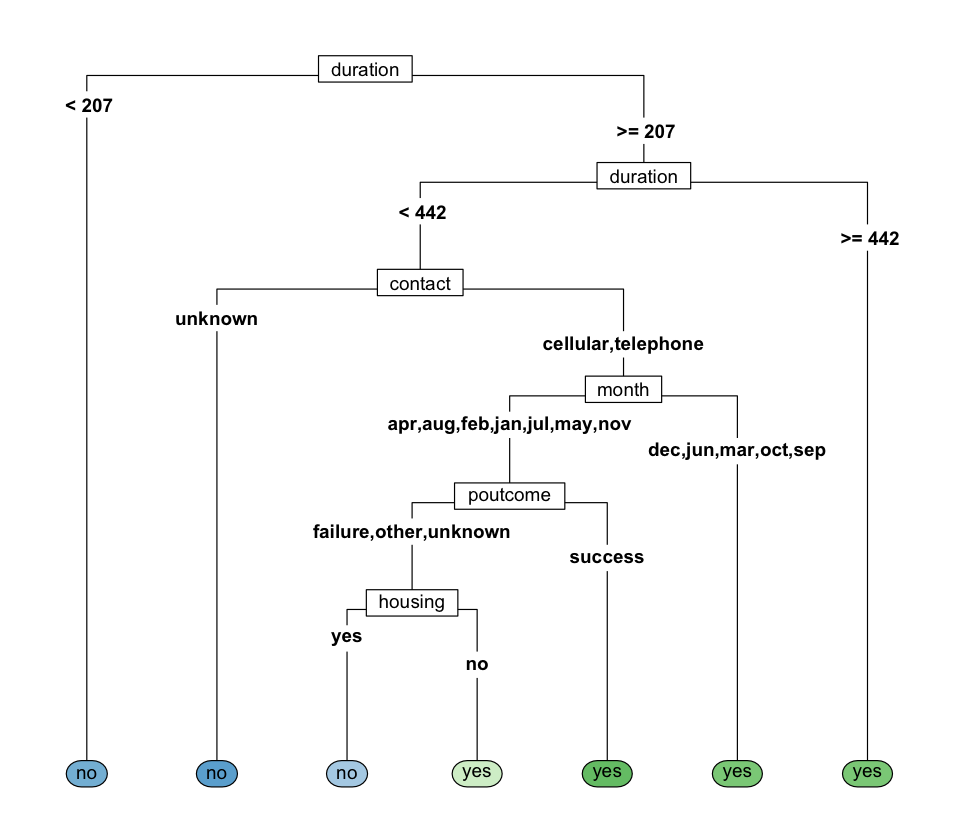

In [12]:
options(repr.plot.width = 8, repr.plot.height = 7)
subtree = prune(tree2, cp = 1.8589e-02)  #1.8589e-02 1.7910e-02
rpart.plot(subtree, extra = 0, type = 5)

Using `cp = 1.8589e-02` that corresponds to `nsplit = 6`, there are 7 terminal nodes for the subtree above. (If using `cp = 1.7910e-02` that corresponds to `nsplit = 8`, there would be 10 terminal nodes.)

The variables used are: `duration`, `contact`, `month`, `poutcome` and `housing`, 5 variables in total.

First of all, these 5 variables show obvious differences for subscribing and not subscribing deposit in the explanatory analysis. Then, here are some details of the consistence of classification to the explanatory analysis:

For `duration`, we can see that in the boxplots in question 1, duration for not subscribing deposit is much smaller than duration for subscribing deposit. It makes sense that in the subtree plot, when duration is larger than 442, the result is subscribing deposit and when duration is smaller than 207, the result is not subcribing deposit;

For `contact`, in the mosaic plot in question 1, most of unknown contact leads to not subscribing deposit. And in the subtree plot, when the contact is unknow, the result is not subscribing.

For `month`, in the mosaic plot in question 1, December, March, October and September has higher proportion in months of subscribing deposit, which is consistent to the classification in the subtree.

For `poutcome`, in the mosaic plot in question 1, unknow poutcome accounts for higher proportion in poutcomes of not subscribing deposit, and success accounts for higher proportion in poutcomes in subscribing deposit, so it also makes sense that success poutcome leads to yes and the others leads to further classification.

For `housing`, in the mosaic plot in question 1 too, not having housing loan accounts for higher proportion in housing of subscribing deposit and having housing loan accounts for higher proportion for not subcribing deposit. And it is consistent to the classification results of the subtree.

### 5. Random Forest

In [13]:
train.data$deposit = as.factor(train.data$deposit)
test.data$deposit = as.factor(test.data$deposit)
rf = randomForest(deposit~., data = train.data, mtry = floor(sqrt(ncol(train.data)-1)), ntree = 1000, 
                  importance = TRUE)
rf


Call:
 randomForest(formula = deposit ~ ., data = train.data, mtry = floor(sqrt(ncol(train.data) -      1)), ntree = 1000, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 4

        OOB estimate of  error rate: 15.17%
Confusion matrix:
      no  yes class.error
no  3407  721   0.1746609
yes  464 3221   0.1259159

In [14]:
train.pred = predict(rf, train.data)
test.pred = predict(rf, test.data)

In [15]:
train.yes.error = mean(train.data$deposit[train.data$deposit=="yes"]!=train.pred[train.data$deposit=="yes"])
train.no.error = mean(train.data$deposit[train.data$deposit=="no"]!=train.pred[train.data$deposit=="no"])
train.error = mean(train.data$deposit!=train.pred)
test.yes.error = mean(test.data$deposit[test.data$deposit=="yes"]!=test.pred[test.data$deposit=="yes"])
test.no.error = mean(test.data$deposit[test.data$deposit=="no"]!=test.pred[test.data$deposit=="no"])
test.error = mean(test.data$deposit!=test.pred)

In [16]:
error.rf = data.frame(Train.Subscribe.Error = train.yes.error,
                    Train.NotSubscribe.Error = train.no.error,
                    Train.Overall.Error = train.error,
                    Test.Subscribe.Error = test.yes.error,
                    Test.NotSubscribe.Error = test.no.error,
                    Test.Overall.Error = test.error
                   )
error = rbind(error.rf, error2)
rownames(error) = c("RandomForest", "SingleTree")
error

,Train.Subscribe.Error,Train.NotSubscribe.Error,Train.Overall.Error,Test.Subscribe.Error,Test.NotSubscribe.Error,Test.Overall.Error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RandomForest,0.00000000,0.0000000,0.0000000,0.1290524,0.1776504,0.1543744
SingleTree,0.09443691,0.1569767,0.1274798,0.1221945,0.1776504,0.1510899


The random forest lowers the overall training error and the training errors for each class significantly. But the random forest gives higher overall test error and test errors for subscribing deposit. I think there might be overfitting problems for random forest which is caused by the small node size.

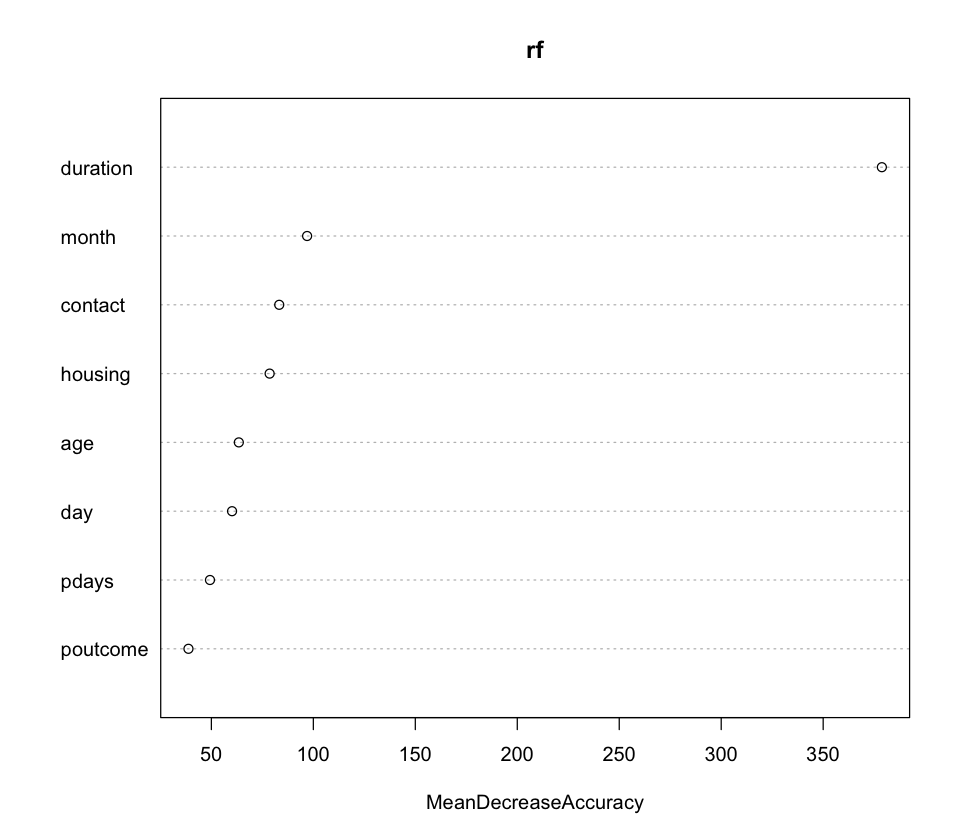

In [17]:
varImpPlot(rf, n.var=8, type=1)

The 8 most important variables given by mean decrease of accuracy are `duration`, `month`, `balance`, `age`, `day`, `contact`, `pdays` and `poutcome`. The 5 variables we found in question 4 are all included in these 8 most important variables.

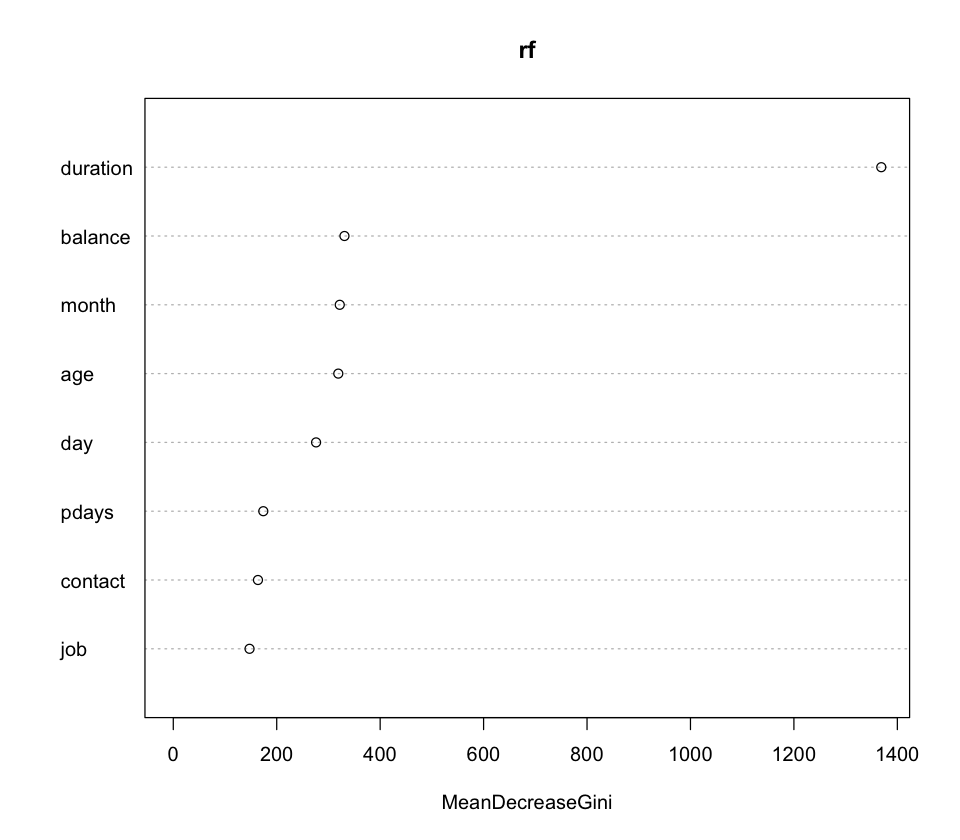

In [18]:
varImpPlot(rf, n.var=8, type=2)

The 8 most important variables given by mean decrease of Gini are pretty different from those given by mean decrease of accuracy. The varibles `housing` and `poutcome` in question 4 are not included in these 8 most important variables.

#### Effect of `mtry`

In [27]:
mtry_error = data.frame(Train.Subscribe.Error = c(0), Train.NotSubscribe.Error = c(0),
                        Train.Overall.Error = c(0), Test.Subscribe.Error = c(0),
                        Test.NotSubscribe.Error = c(0), Test.Overall.Error = c(0)
                       )
mtrys = c(1:16)
for (m in mtrys){
    rf.tmp = randomForest(deposit~., data = train.data, mtry = m)
    train.pred = predict(rf.tmp, train.data)
    test.pred = predict(rf.tmp, test.data)
    train.yes.error = mean(train.data$deposit[train.data$deposit=="yes"]!=train.pred[train.data$deposit=="yes"])
    train.no.error = mean(train.data$deposit[train.data$deposit=="no"]!=train.pred[train.data$deposit=="no"])
    train.error = mean(train.data$deposit!=train.pred)
    test.yes.error = mean(test.data$deposit[test.data$deposit=="yes"]!=test.pred[test.data$deposit=="yes"])
    test.no.error = mean(test.data$deposit[test.data$deposit=="no"]!=test.pred[test.data$deposit=="no"])
    test.error = mean(test.data$deposit!=test.pred)
    mtry_error = rbind(mtry_error, 
                       c(train.yes.error, train.no.error, train.error, test.yes.error, test.no.error, test.error)
                      )
}
mtry_error = mtry_error[-1, ]

In [29]:
mtry_error$mtry = mtrys

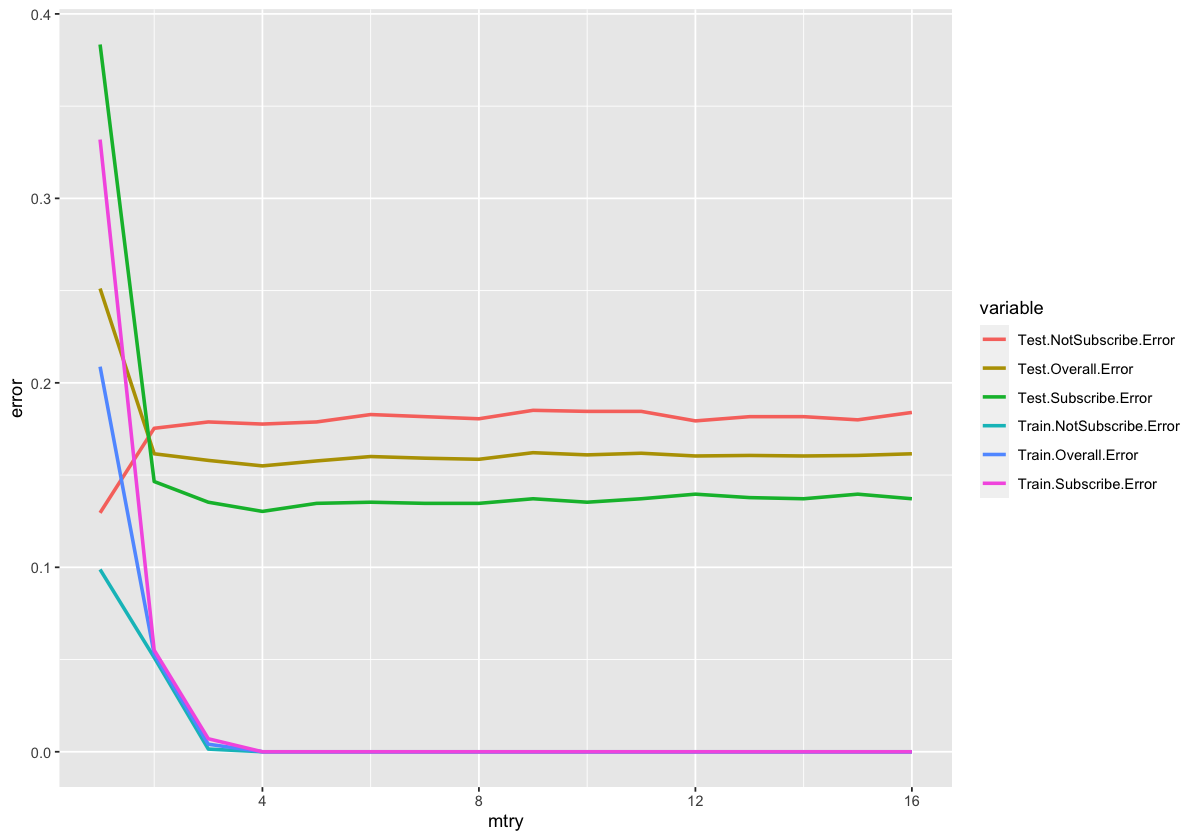

In [38]:
options(repr.plot.width = 10, repr.plot.height = 7)
mtry_error %>% gather(key = "variable", value = "error", -mtry) %>%
    ggplot(mapping = aes(x = mtry, y = error, color = variable)) + geom_line(size = 1)

As `mtry` increases, all three training errors decreases to 0; the overall test error and the test error for subscribing deposit decreases first and then increases a little; the test error for not subscribing deposit increases as `mtry` increases, which is kind of strange. But the increase is not large enough to affect the trend of the overall test error.

#### Effect of `ntree`

In [41]:
ntree_error = data.frame(Train.Subscribe.Error = c(0), Train.NotSubscribe.Error = c(0),
                        Train.Overall.Error = c(0), Test.Subscribe.Error = c(0),
                        Test.NotSubscribe.Error = c(0), Test.Overall.Error = c(0)
                       )
ntrees = c(100, 200, 300, 500, 1000, 1500, 2000, 3000, 5000)
for (n in ntrees){
    rf.tmp = randomForest(deposit~., data = train.data, mtry = 4, ntree = n)
    train.pred = predict(rf.tmp, train.data)
    test.pred = predict(rf.tmp, test.data)
    train.yes.error = mean(train.data$deposit[train.data$deposit=="yes"]!=train.pred[train.data$deposit=="yes"])
    train.no.error = mean(train.data$deposit[train.data$deposit=="no"]!=train.pred[train.data$deposit=="no"])
    train.error = mean(train.data$deposit!=train.pred)
    test.yes.error = mean(test.data$deposit[test.data$deposit=="yes"]!=test.pred[test.data$deposit=="yes"])
    test.no.error = mean(test.data$deposit[test.data$deposit=="no"]!=test.pred[test.data$deposit=="no"])
    test.error = mean(test.data$deposit!=test.pred)
    ntree_error = rbind(ntree_error, 
                        c(train.yes.error, train.no.error, train.error, test.yes.error, test.no.error, test.error)
                       )
}
ntree_error = ntree_error[-1, ]

In [42]:
ntree_error$ntree = ntrees

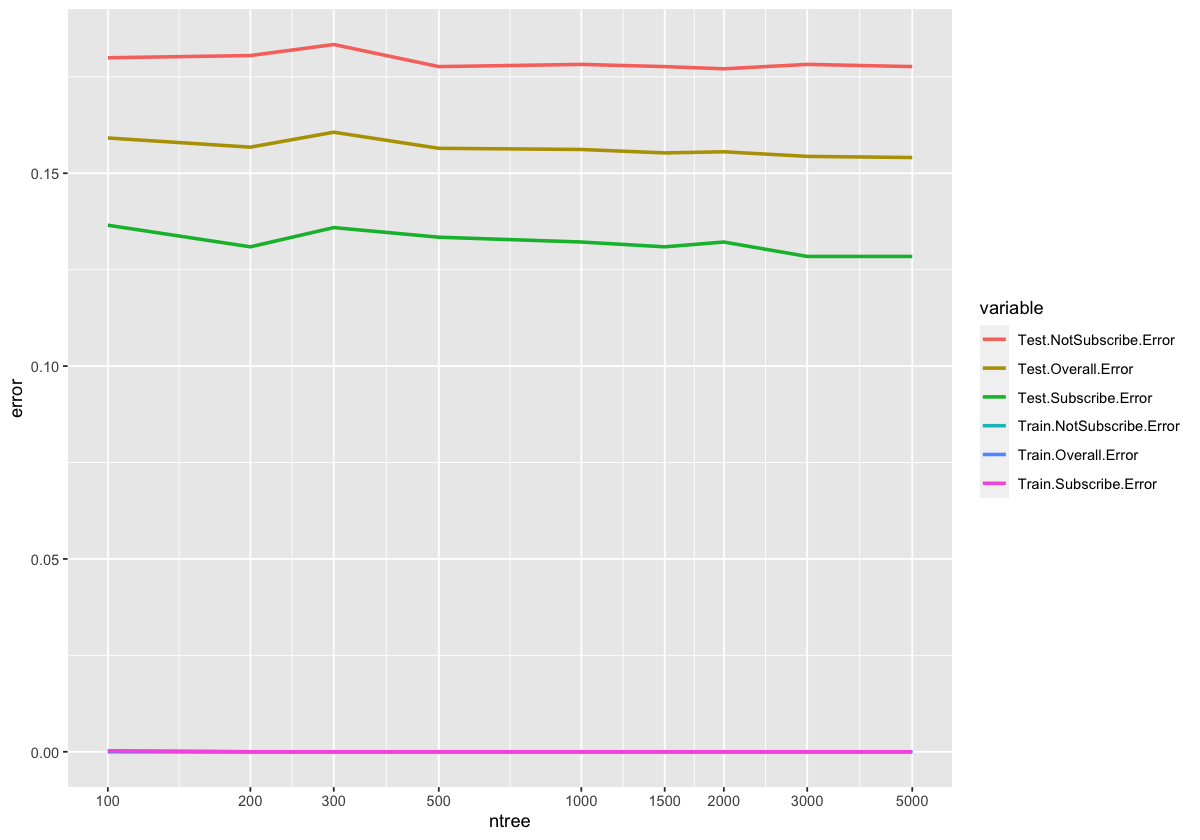

In [44]:
options(repr.plot.width = 10, repr.plot.height = 7)
ntree_error %>% gather(key = "variable", value = "error", -ntree) %>%
    ggplot(mapping = aes(x = ntree, y = error, color = variable)) + geom_line(size = 1) + 
    scale_x_continuous(trans = "log", breaks = ntrees)

As `ntree` increases, the overall training error and the training errors for each class are always 0; the whole trend for all three kinds of test errors is decreasing slowly, although there might be some small fluctuation.

#### Effect of `nodesize`

In [48]:
nsize_error = data.frame(Train.Subscribe.Error = c(0), Train.NotSubscribe.Error = c(0),
                        Train.Overall.Error = c(0), Test.Subscribe.Error = c(0),
                        Test.NotSubscribe.Error = c(0), Test.Overall.Error = c(0)
                       )
nsizes = c(1, 5, 7, 10, 15, 20, 50, 100, 150, 200)
for (n in nsizes){
    rf.tmp = randomForest(deposit~., data = train.data, mtry = 4, ntree = 500, nodesize = n)
    train.pred = predict(rf.tmp, train.data)
    test.pred = predict(rf.tmp, test.data)
    train.yes.error = mean(train.data$deposit[train.data$deposit=="yes"]!=train.pred[train.data$deposit=="yes"])
    train.no.error = mean(train.data$deposit[train.data$deposit=="no"]!=train.pred[train.data$deposit=="no"])
    train.error = mean(train.data$deposit!=train.pred)
    test.yes.error = mean(test.data$deposit[test.data$deposit=="yes"]!=test.pred[test.data$deposit=="yes"])
    test.no.error = mean(test.data$deposit[test.data$deposit=="no"]!=test.pred[test.data$deposit=="no"])
    test.error = mean(test.data$deposit!=test.pred)
    nsize_error = rbind(nsize_error, 
                        c(train.yes.error, train.no.error, train.error, test.yes.error, test.no.error, test.error)
                       )
}
nsize_error = nsize_error[-1, ]

In [49]:
nsize_error$nodesize = nsizes

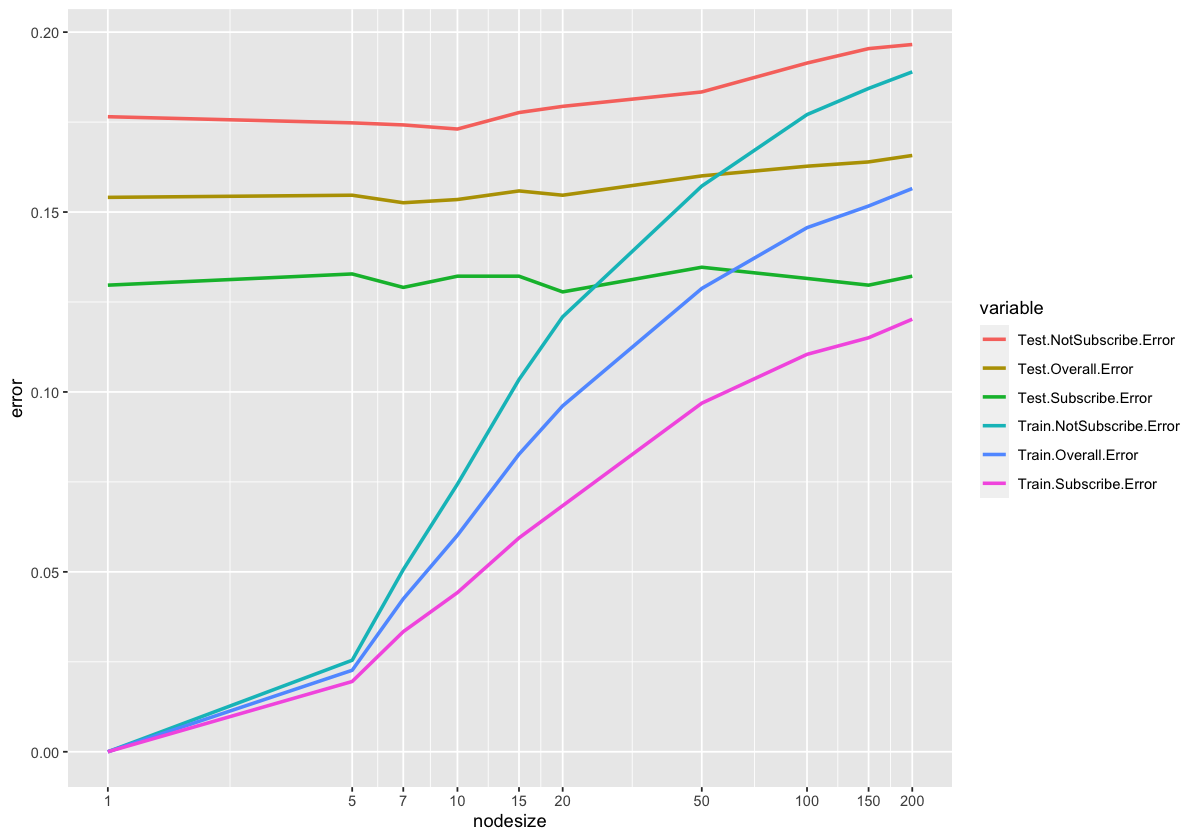

In [51]:
options(repr.plot.width = 10, repr.plot.height = 7)
nsize_error %>% gather(key = "variable", value = "error", -nodesize) %>%
    ggplot(mapping = aes(x = nodesize, y = error, color = variable)) + geom_line(size = 1) + 
    scale_x_continuous(trans = "log", breaks = nsizes)

As `nodesize` increases, the overall training error and the training errors for each class increase; the overall test error and the test error for not subscribing deposit decreases at first and then increases, but the trend of test error for subscribing deposit is kind of fluctuating.

### 6.

In [19]:
# change all char variables to factor
train.data[sapply(train.data, is.character)] = lapply(train.data[sapply(train.data, is.character)], as.factor)
test.data[sapply(test.data, is.character)] = lapply(test.data[sapply(test.data, is.character)], as.factor)

In [20]:
train.data$deposit = ifelse(train.data$deposit=="yes", 1, 0)
test.data$deposit = ifelse(test.data$deposit=="yes", 1, 0)

In [23]:
adabst = gbm(deposit~., data = train.data, distribution = "adaboost", n.trees = 1000, 
             interaction.depth = 5, shrinkage = 0.05)

In [24]:
train.pred = ifelse(predict(adabst, train.data, type = "response", n.trees = 1000)>0.5, 1, 0)
test.pred = ifelse(predict(adabst, test.data, type = "response", n.trees = 1000)>0.5, 1, 0)

In [25]:
train.yes.error = mean(train.data$deposit[train.data$deposit==1]!=train.pred[train.data$deposit==1])
train.no.error = mean(train.data$deposit[train.data$deposit==0]!=train.pred[train.data$deposit==0])
train.error = mean(train.data$deposit!=train.pred)
test.yes.error = mean(test.data$deposit[test.data$deposit==1]!=test.pred[test.data$deposit==1])
test.no.error = mean(test.data$deposit[test.data$deposit==0]!=test.pred[test.data$deposit==0])
test.error = mean(test.data$deposit!=test.pred)

In [26]:
error.ada = data.frame(Train.Subscribe.Error = train.yes.error,
                    Train.NotSubscribe.Error = train.no.error,
                    Train.Overall.Error = train.error,
                    Test.Subscribe.Error = test.yes.error,
                    Test.NotSubscribe.Error = test.no.error,
                    Test.Overall.Error = test.error
                   )
error = rbind(error.ada, error.rf, error2)
rownames(error) = c("AdaBoost", "RandomForest", "SingleTree")
error

,Train.Subscribe.Error,Train.NotSubscribe.Error,Train.Overall.Error,Test.Subscribe.Error,Test.NotSubscribe.Error,Test.Overall.Error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AdaBoost,0.08493894,0.1189438,0.1029054,0.1215711,0.1535817,0.1382502
RandomForest,0.00000000,0.0000000,0.0000000,0.1290524,0.1776504,0.1543744
SingleTree,0.09443691,0.1569767,0.1274798,0.1221945,0.1776504,0.1510899


AdaBoost gives smaller training errors (overall and each class) than the single tree model. And in terms of overall test error and test errors for each class, Adaboost performs best among these three models. 

,var,rel.inf
,<chr>,<dbl>
duration,duration,32.92498906
month,month,21.83364392
job,job,7.58463716
poutcome,poutcome,7.01557350
balance,balance,6.10907388
day,day,5.30976546
age,age,4.82836897
contact,contact,4.58575538
pdays,pdays,3.47495484


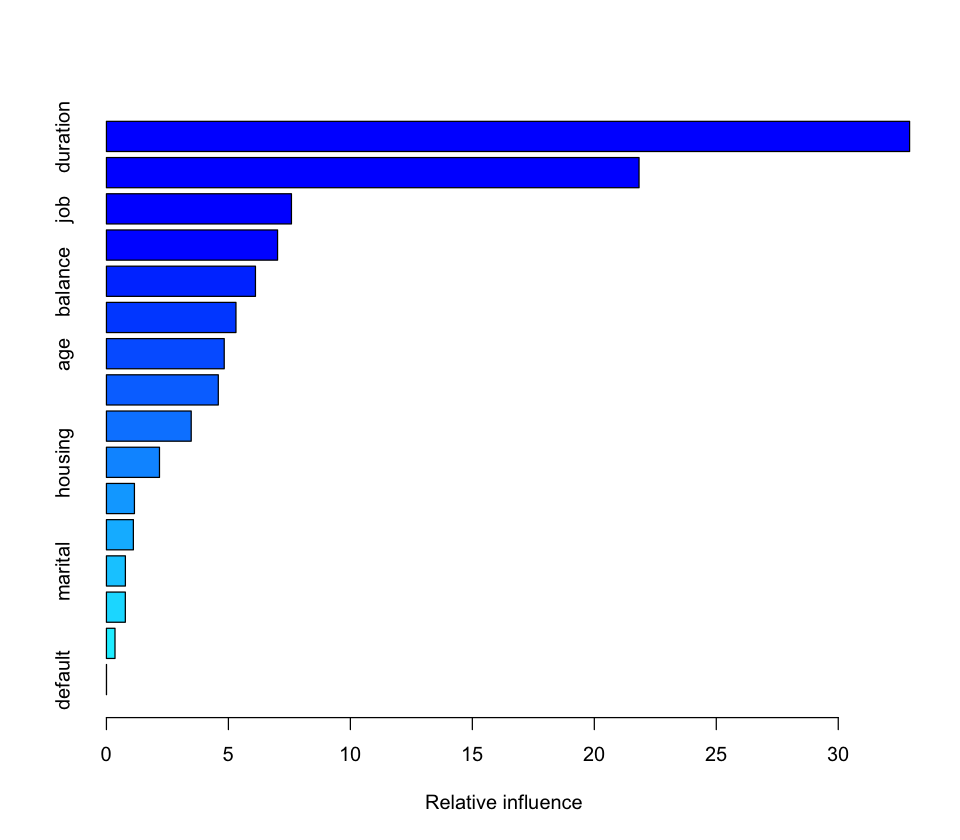

In [27]:
summary(adabst)

The 8 most important variables:

|   | Mean Decrease of Accuracy (RandomForest)  | Mean Decrease of Gini (RandomForest) | AdaBoost | 
|---|---|---|---|
|1  | `duration`  | `duration`  | `duration`  |
|2  | `month`  | `balance`  | `month`  | 
|3  | `balance`  | `month`  |  `job` | 
|4  | `age`  | `age`  | `poutcome`  | 
|5  | `day`  | `day`  | `balance`  | 
|6  | `contact`  | `pdays`  | `day`  | 
|7  | `pdays`  | `contact`  | `age`  | 
|8  | `poutcome`  | `job`  | `contact`  | 


It can be seen that the 8 most important variables given by AdaBoost is similar to the 8 most important variables given by random forest, altough the order might be slightly different. The variable `duration` has the largest importance for both models.

#### Effect of `interaction.depth`

In [53]:
idepth_error = data.frame(Train.Subscribe.Error = c(0), Train.NotSubscribe.Error = c(0),
                        Train.Overall.Error = c(0), Test.Subscribe.Error = c(0),
                        Test.NotSubscribe.Error = c(0), Test.Overall.Error = c(0)
                       )
i.depths = c(2:17)
for (d in i.depths){
    ada.tmp = gbm(deposit~., data = train.data, distribution = "adaboost", n.trees = 1000, 
                  interaction.depth = d, shrinkage = 0.1)
    train.pred = ifelse(predict(ada.tmp, train.data, type = "response", n.trees = 1000)>0.5, 1, 0)
    test.pred = ifelse(predict(ada.tmp, test.data, type = "response", n.trees = 1000)>0.5, 1, 0)
    train.yes.error = mean(train.data$deposit[train.data$deposit==1]!=train.pred[train.data$deposit==1])
    train.no.error = mean(train.data$deposit[train.data$deposit==0]!=train.pred[train.data$deposit==0])
    train.error = mean(train.data$deposit!=train.pred)
    test.yes.error = mean(test.data$deposit[test.data$deposit==1]!=test.pred[test.data$deposit==1])
    test.no.error = mean(test.data$deposit[test.data$deposit==0]!=test.pred[test.data$deposit==0])
    test.error = mean(test.data$deposit!=test.pred)
    idepth_error = rbind(idepth_error, 
                         c(train.yes.error, train.no.error, train.error, test.yes.error, test.no.error, test.error)
                        )
}
idepth_error = idepth_error[-1, ]

In [54]:
idepth_error$i.depth = i.depths

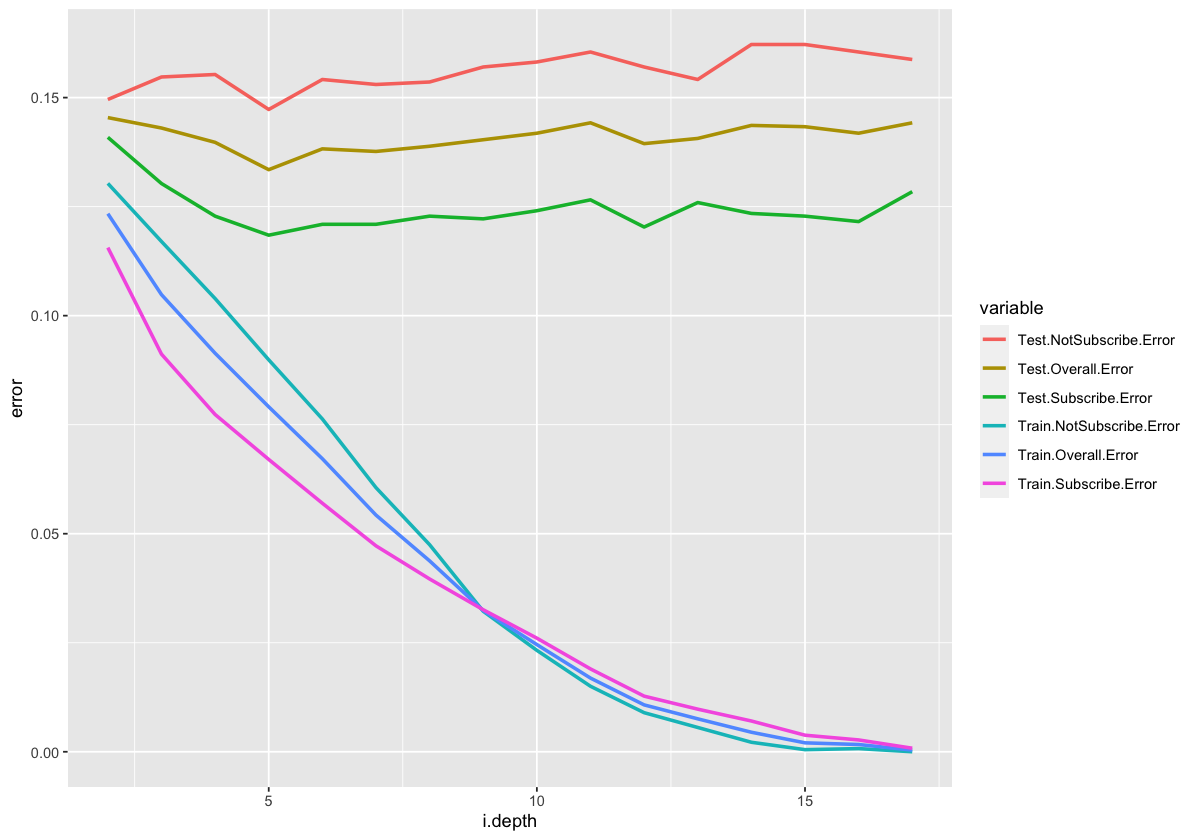

In [56]:
options(repr.plot.width = 10, repr.plot.height = 7)
idepth_error %>% gather(key = "variable", value = "error", -i.depth) %>%
    ggplot(mapping = aes(x = i.depth, y = error, color = variable)) + geom_line(size = 1)

As `interaction.depth` increases, three training errors (overall and for each class) decreases; three test errors (overall and for each class) decreases first and then increases with fluctutation. And it seems that when `interaction.depth` = 5, the three test errors reach their minimum.

#### Effect of  `shrinkage`

In [62]:
shrink_error = data.frame(Train.Subscribe.Error = c(0), Train.NotSubscribe.Error = c(0),
                          Train.Overall.Error = c(0), Test.Subscribe.Error = c(0),
                          Test.NotSubscribe.Error = c(0), Test.Overall.Error = c(0)
                         )
shrinkages = c(0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1)
for (s in shrinkages){
    ada.tmp = gbm(deposit~., data = train.data, distribution = "adaboost", n.trees = 1000, 
                  interaction.depth = 5, shrinkage = s)
    train.pred = ifelse(predict(ada.tmp, train.data, type = "response", n.trees = 1000)>0.5, 1, 0)
    test.pred = ifelse(predict(ada.tmp, test.data, type = "response", n.trees = 1000)>0.5, 1, 0)
    train.yes.error = mean(train.data$deposit[train.data$deposit==1]!=train.pred[train.data$deposit==1])
    train.no.error = mean(train.data$deposit[train.data$deposit==0]!=train.pred[train.data$deposit==0])
    train.error = mean(train.data$deposit!=train.pred)
    test.yes.error = mean(test.data$deposit[test.data$deposit==1]!=test.pred[test.data$deposit==1])
    test.no.error = mean(test.data$deposit[test.data$deposit==0]!=test.pred[test.data$deposit==0])
    test.error = mean(test.data$deposit!=test.pred)
    shrink_error = rbind(shrink_error, 
                         c(train.yes.error, train.no.error, train.error, test.yes.error, test.no.error, test.error)
                        )
}
shrink_error = shrink_error[-1, ]

In [63]:
shrink_error$shrinkage = shrinkages

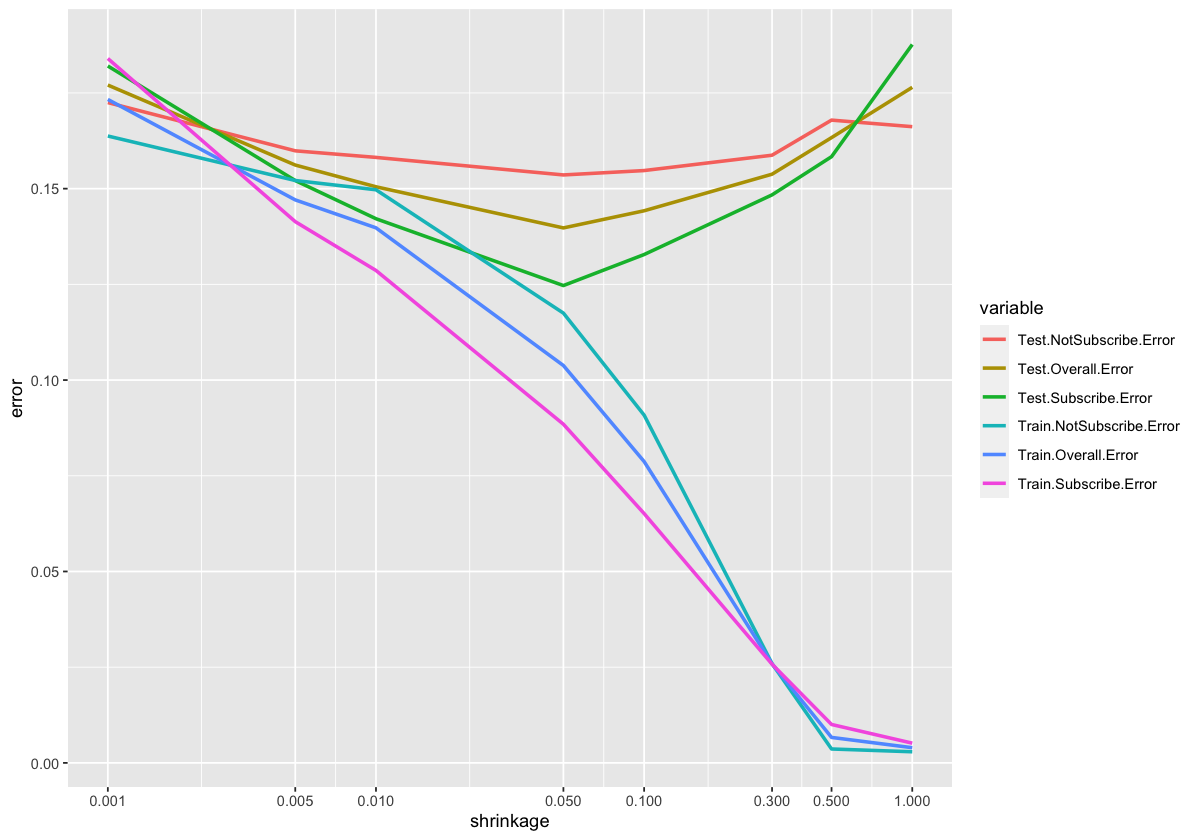

In [64]:
options(repr.plot.width = 10, repr.plot.height = 7)
shrink_error %>% gather(key = "variable", value = "error", -shrinkage) %>%
    ggplot(mapping = aes(x = shrinkage, y = error, color = variable)) + geom_line(size = 1) + 
    scale_x_continuous(trans = "log", breaks = shrinkages)

As `shrinkage` increases, three training errors (overall and for each class) decreases; three test errors (overall and for each class) decreases at first and then increases. When `shrinkage` = 0.05, three test errors reach their minimum.

#### Effect of  `n.trees`

In [67]:
ntree_error = data.frame(Train.Subscribe.Error = c(0), Train.NotSubscribe.Error = c(0),
                        Train.Overall.Error = c(0), Test.Subscribe.Error = c(0),
                        Test.NotSubscribe.Error = c(0), Test.Overall.Error = c(0)
                       )
ntrees = c(100, 200, 300, 500, 1000, 1500, 2000, 3000, 5000)
for (n in ntrees){
    ada.tmp = gbm(deposit~., data = train.data, distribution = "adaboost", n.trees = n, 
                  interaction.depth = 5, shrinkage = 0.05)
    train.pred = ifelse(predict(ada.tmp, train.data, type = "response", n.trees = n)>0.5, 1, 0)
    test.pred = ifelse(predict(ada.tmp, test.data, type = "response", n.trees = n)>0.5, 1, 0)
    train.yes.error = mean(train.data$deposit[train.data$deposit==1]!=train.pred[train.data$deposit==1])
    train.no.error = mean(train.data$deposit[train.data$deposit==0]!=train.pred[train.data$deposit==0])
    train.error = mean(train.data$deposit!=train.pred)
    test.yes.error = mean(test.data$deposit[test.data$deposit==1]!=test.pred[test.data$deposit==1])
    test.no.error = mean(test.data$deposit[test.data$deposit==0]!=test.pred[test.data$deposit==0])
    test.error = mean(test.data$deposit!=test.pred)
    ntree_error = rbind(ntree_error, 
                        c(train.yes.error, train.no.error, train.error, test.yes.error, test.no.error, test.error)
                       )
}
ntree_error = ntree_error[-1, ]

In [68]:
ntree_error$n.trees = ntrees

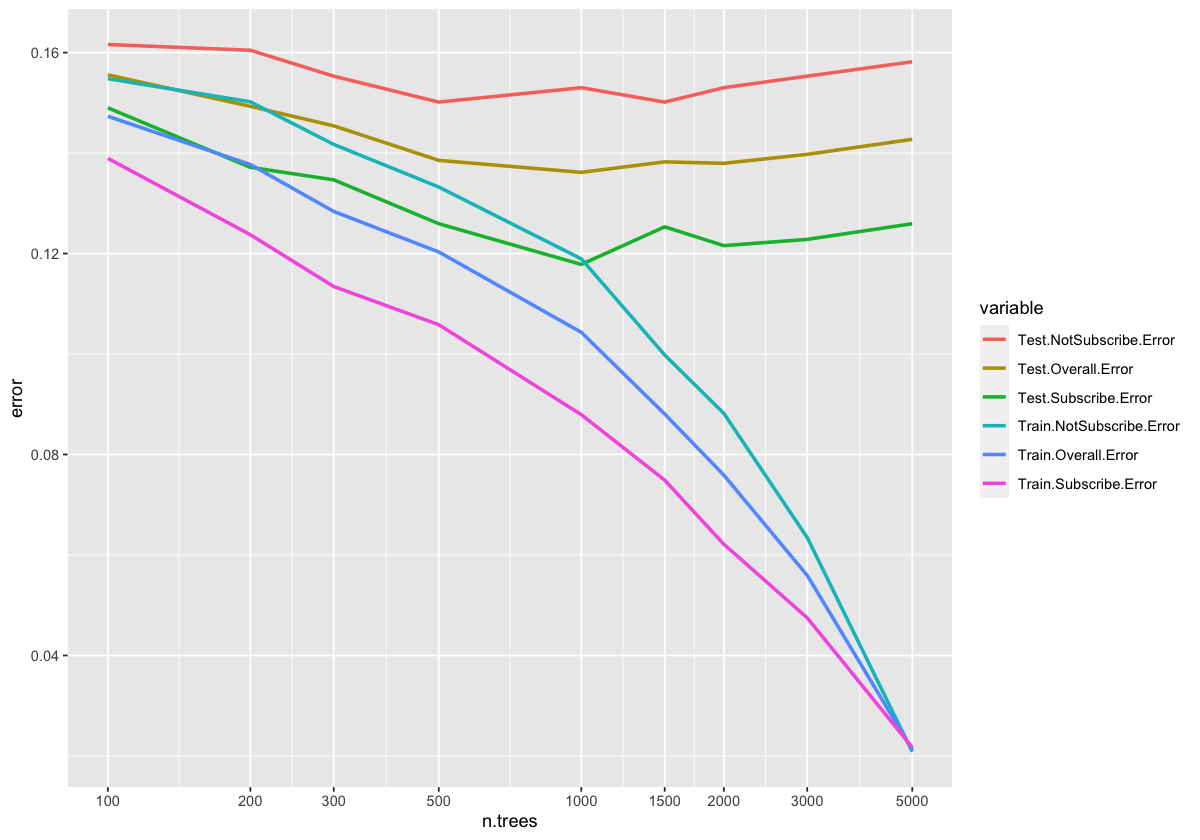

In [70]:
options(repr.plot.width = 10, repr.plot.height = 7)
ntree_error %>% gather(key = "variable", value = "error", -n.trees) %>%
    ggplot(mapping = aes(x = n.trees, y = error, color = variable)) + geom_line(size = 1) + 
    scale_x_continuous(trans = "log", breaks = ntrees)

As `n.trees` increases, three training errors (overall and for each class) decreases; three test errors (overall and for each class) decreases at first and then increases (overfitting problem). When `n.trees` = 1000, overall test errors and test error for subscribing deposit reach their minimum; when `n.trees` = 500, test error for not subscribing deposit reaches its minimum.